# Introduction

This is an overview of my progress this far. I attempted to perform ECG feature extraction with the help of the fast Fourier Transform (FFT). I chose to use the [Julia](https://julialang.org/) programming language, a free, open source, fast, and scientific programming language.

As of now I have not been successful in extracting features using FFT. I can perform the FFT, but how to get from there to feature recognition is not clear to me. I have not found a paper in which the process was explained in a way that I could replicate it. I am still working on this issue. Below you can find my current progress.

The ECG data that I used is an [MITBIH](https://www.physionet.org/content/mitdb/1.0.0/) ECG file (number 100; downloaded and converted to csv using [WFDB](https://archive.physionet.org/physiotools/wfdb.shtml)).

# Hand-coded FFT Processing

In this section I perform most parts of the analysis by coding it myself instead of using a library to do all the work. This was my first approach. The code below is annotated to improve clarity. In case of questions please ask me.

In [1]:
# plotting library 
using Plots; gr()
# library for FFT, signal processing, data importing, matrices
using FFTW, DSP, CSV, Tables

# read in the ecg file as a matrix (CSV and Tables libraries)
ecg_matrix = CSV.File("../mitbih/100.csv.mitbih") |> Tables.matrix

# set the sampling frequency (based on the ECG data)
fs = 360     # 360 samples per second

# set the used segment to the first 2 seconds
N  = 2 * fs;  # equivalent to 2 seconds

In [2]:
# create a smaller section of the ECG to use
ecg = ecg_matrix[1:N, 1:2]
length(ecg)

1440

In [3]:
# create a simple digital filter (DSP library)
digital_filter = digitalfilter(Lowpass(0.15), Butterworth(1))

ZeroPoleGain{Complex{Float64},Complex{Float64},Float64}(Complex{Float64}[-1.0 + 0.0im], Complex{Float64}[0.612800788139932 + 0.0im], 0.19359960593003397)

In [4]:
# create a filtered version of the ECG
ecg_filtered = copy(ecg);

In [5]:
ecg_filtered[:,2] = filt(digital_filter, ecg[:,2])

LoadError: StackOverflowError:

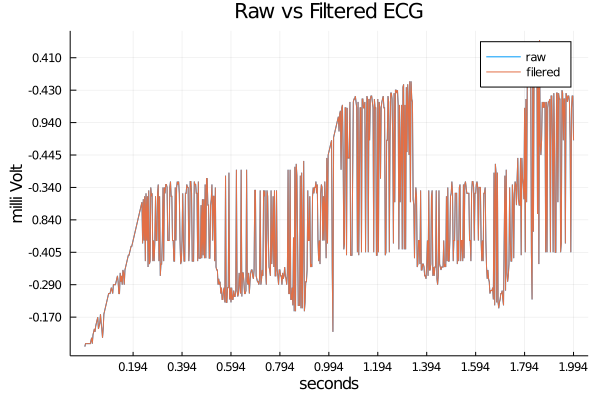

In [6]:
# plot the raw and filtered ECGs for comparison (Plots library)
plot(ecg[:,1], ecg[:,2], title="Raw vs Filtered ECG", label="raw")
plot!(ecg_filtered[:,1], ecg_filtered[:,2], xlabel="seconds", ylabel="milli Volt", label="filered")

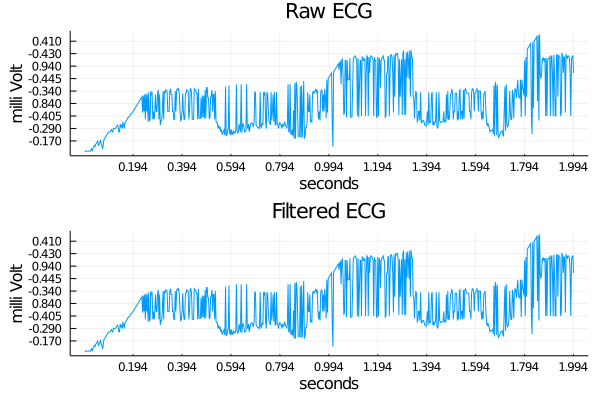

In [7]:
# create a side-by-side plot of the raw and filtered ECG (Plots library)
p1 = plot(ecg[:,1], ecg[:,2], title="Raw ECG", xlabel="seconds", ylabel="milli Volt")
p2 = plot(ecg_filtered[:,1], ecg_filtered[:,2], title="Filtered ECG", xlabel="seconds", ylabel="milli Volt")
plot(p1, p2, layout=(2,1), label="")

In [8]:
frequencies = 2:div(N,2)+1

# create a FFT of the raw ECG signal (FFTW library)
F  = 1 / N * fft(ecg[:,2])[frequencies]

# create a FFT of the filtered ECG signal (FFTW library)
F_filtered = 1 / N * fft(ecg_filtered[:,2])[frequencies]

# plot the FFTs 

p3 = plot(frequencies, abs.(F), title="Raw ECG FFT")
p4 = plot(frequencies, abs.(F_filtered), title="Filtered ECG FFT")
plot(p3, p4, layout=(2,1), label="")

LoadError: MethodError: no method matching plan_fft(::Array{String,1}, ::UnitRange{Int64})
Closest candidates are:
  plan_fft(!Matched::StridedArray{T, N}, ::Any; flags, timelimit) where {T<:Union{Complex{Float32}, Complex{Float64}}, N} at /home/moritz/.julia/packages/FFTW/eADNB/src/fft.jl:681
  plan_fft(!Matched::AbstractArray{var"#s17",N} where N where var"#s17"<:Real, ::Any; kws...) at /home/moritz/.julia/packages/AbstractFFTs/JAxy0/src/definitions.jl:199
  plan_fft(!Matched::AbstractArray{var"#s26",N} where N where var"#s26"<:(Complex{var"#s27"} where var"#s27"<:Union{Integer, Rational}), ::Any; kws...) at /home/moritz/.julia/packages/AbstractFFTs/JAxy0/src/definitions.jl:201
  ...

In [9]:
# plotting phase spectrums
phase_list = [atan(imag(i), real(i)) for i in F] * 180 / pi
p5 = plot(frequencies, phase_list, seriestype = :scatter, label="", title="Raw ECG Spectrum")
phase_list_filtered = [atan(imag(i), real(i)) for i in F_filtered] * 180 / pi
p6 = plot(frequencies, phase_list_filtered, seriestype = :scatter, label="", title="Filtered ECG Spectrum")
plot(p5, p6, layout=(2,1), label="")

LoadError: UndefVarError: F not defined

# FFT Processing using a library

In this section I perform the same operations as before, but I use a library to do most of the work for me.

This code works as an extension of the code above and I am reusing the exact same values/arrays for the ecg.

In [10]:
# importing the new library
using FourierAnalysis

# computing fouriers spectra with library and plotting them
spec          = spectra(ecg[:,2], fs, N; tapering=rectangular, func=√)
spec_filtered = spectra(ecg_filtered[:,2], fs, N; tapering=rectangular, func=√)

p7 = plot(abs.(spec.y[brange(N),:]), title="Raw ECG FFT")
p8 = plot(abs.(spec_filtered.y[brange(N),:]), title="Filtered ECG FFT")

plot(p7, p8, layout=(2,1), label="")

LoadError: MethodError: no method matching spectra(::Array{String,1}, ::Int64, ::Int64; tapering=rectangular, func=sqrt)
Closest candidates are:
  spectra(!Matched::Union{Array{T,1}, Array{T,2}}, ::Int64, ::Int64; tapering, planner, slide, DC, func, smoothing, ⏩) where T<:Real at /home/moritz/.julia/packages/FourierAnalysis/gGTl4/src/spectra.jl:326
  spectra(!Matched::Array{Array{T,2},1}, ::Int64, ::Int64; tapering, planner, slide, DC, func, smoothing, ⏩) where T<:Real at /home/moritz/.julia/packages/FourierAnalysis/gGTl4/src/spectra.jl:368

Below I show that both approaches yield the same ECG (given some minor error probably caused by different numeric approaches).

In [11]:
# illustration that the two approaches are identical
print("Max Difference raw FFTs: ")
println(maximum(abs.(F) - abs.(spec.y[brange(N),:])))

print("Max Difference filtered FFTs: ")
println(maximum(abs.(F_filtered) - abs.(spec_filtered.y[brange(N),:])))

Max Difference raw FFTs: 

LoadError: UndefVarError: F not defined

This is as far as I progressed this far. I will continue to work on this. Any feedback is greatly appreatiated.